In [1]:
#IMPORT LIBRARIES
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
#HYPER PARMETERS
latent_dim = 5 ##latent_dim must be the same value like set_latent_dim in training_cgan.ipynb
number_classes = 10 ##number_classes must be the same value like number_classes in training_cgan.ipynb

In [3]:
# UTILIZABLE LABEL FUNCTION
def random_onehot_labels(batch_size):
    labels= []
    batch = torch.zeros(batch_size, 10)
    for b in batch:
        label = random.randint(0, 9)
        b[label] = 1
        labels.append(label)
    return labels, batch

# UTILIZABLE MODELS
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) ##input.size(0): batch size
##--------------------------------------------------------------------------------------------------------------   
class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 4, 4)
##--------------------------------------------------------------------------------------------------------------   
class Concat(nn.Module):
    def forward(self, x):
        x1 = x[0]
        x2 = x[1]
        return torch.cat((x1, x2), 1)     

In [4]:
#DEFINE MODEL
class CGAN(torch.nn.Module): ##CGAN: Conditional Generative Adversarial Network
    def __init__(self):
        super(CGAN, self).__init__()
        ##discrimation part
        self.discriminator_img = nn.Sequential(
            ###batch_sizex1x32x32 => batch_sizex64x16x16
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.discriminator_y = nn.Sequential(
            ###batch_sizex10x32x32 => batch_sizex64x16x16
            nn.Conv2d(in_channels=number_classes, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
            
        )
        self.discriminator = nn.Sequential(
            ###batch_sizex128x16x16
            Concat(),
            ###batch_sizex128x16x16 => batch_sizex256x8x8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x8x8 => batch_sizex512x4x4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            ###batch_sizex512*4*4
            nn.Flatten(),
            ###batch_sizex1
            nn.Linear(512*4*4, 1, bias=False)
        )

        ##generator part
        self.generator_z = nn.Sequential(
            ###batch_sizex256*4*4
            nn.Linear(latent_dim, 256*4*4, bias=False),
            nn.BatchNorm1d(256*4*4),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x4x4
            Reshape1()
        )
        self.generator_y = nn.Sequential(
            ###batch_sizex256*4*4
            nn.Linear(number_classes, 256*4*4, bias=False),
            nn.BatchNorm1d(256*4*4),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x4x4
            Reshape1()
        )
        self.generator = nn.Sequential(
            ### batch_sizex512x4x4
            Concat(), 
            ###batch_sizex512x4x4 => batch_sizex256x8x8
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ###batch_sizex256x8x8 => batch_sizex128x16x16
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2), 
            ###batch_sizex128x16x16 => batch_sizex1x32x32
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )     
    
    def generator_forward(self, z, y):
        out1 = self.generator_z(z)
        out2 = self.generator_y(y)
        return self.generator([out1, out2])
    
    def discriminator_forward(self, img, y):
        out1 = self.discriminator_img(img)
        out2 = self.discriminator_y(y)
        out = self.discriminator([out1, out2])
        return out

In [5]:
#SETUP MODEL
#DEVICE AND TRANSFORM
##current device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
##transfrom image
custom_transform = transforms.Compose([
    transforms.Resize(32),###make image size 32x32
    transforms.ToTensor() ###scale input image to 0-1 range
])

##load model
model = CGAN()
model.to(device)
model.load_state_dict(torch.load('./static/inference/MATH4KID.pt', map_location=device))
model.eval() 
print()

In [6]:
##math for kids function 
def math4kids():
    ## make new tensor images
    batch_size = 2
    z = torch.zeros((batch_size, latent_dim)).uniform_(-1.0, 1.0).to(device)
    actual_labels, y = random_onehot_labels(batch_size)
    y = y.to(device)
    generated_features = model.generator_forward(z, y)
    imgs = generated_features.view(-1, 32, 32)

    ##operator
    operator = random.randint(0, 2)
    first_operand, second_operand = actual_labels
    if operator == 0: ##addition
        image_operator = Image.open('static/inference/plus.jpeg')
        result = first_operand + second_operand
    elif operator == 1: ## subtraction
        image_operator = Image.open('static/inference/minus.jpeg')
        result = first_operand - second_operand
    else: ## multiplication
        image_operator = Image.open('static/inference/time.jpeg')
        result = first_operand * second_operand
    
    ##show operand and operator images
    fig = plt.figure(figsize = (10,2.5))
    #first operand axis
    ax1 = fig.add_subplot(1,5,1)
    ax1.axis('off')
    ax1.imshow(imgs[0].to(torch.device('cpu')).detach(), cmap='Blues')
    ##second operand axis
    ax2 = fig.add_subplot(1,5,2)
    ax2.axis('off')
    ax2.imshow(image_operator)
    ## third operand axis
    ax3 = fig.add_subplot(1,5,3)
    ax3.axis('off')
    ax3.imshow(imgs[1].to(torch.device('cpu')).detach(), cmap='Blues')
    ## fourth axis
    ax4 = fig.add_subplot(1,5,4)
    ax4.axis('off')
    image_equal = Image.open('static/inference/equal.jpeg')
    ax4.imshow(image_equal)
    ## fifth axis
    ax5 = fig.add_subplot(1,5,5)
    ax5.axis('off')
    image_question = Image.open('static/inference/question.jpeg')
    ax5.imshow(image_question)
    plt.show()
    
    #hit the enter key to submit the answer
    kid_answer = input("Please type your answer here: ") 

    #check the answer
    first_operand, second_operand = actual_labels
    str_operator = ['+', '-', '*']
    if int(kid_answer) == result:
        print('Way to go!')
    else:
        print(f'The answer is: {first_operand} {str_operator[operator]} {second_operand} = {result}')
        print('Better luck next time!')
        

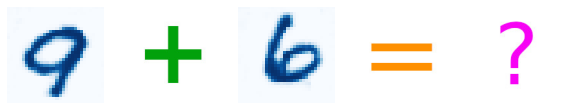

Please type your answer here: 15
Way to go!


In [7]:
math4kids()

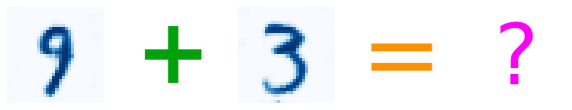

Please type your answer here: 93
The answer is: 9 + 3 = 12
Better luck next time!


In [8]:
math4kids()

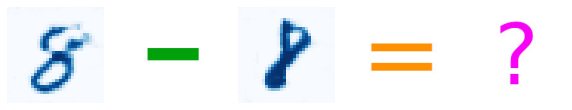

Please type your answer here: 0
Way to go!


In [9]:
math4kids()

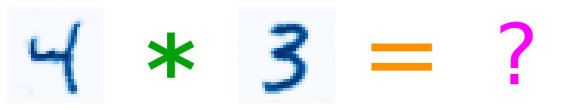

Please type your answer here: 12
Way to go!


In [10]:
math4kids()